# Onderzoeksvoorstel

## Introductie

Macaulays methode is een methode waarmee de verplaatsingsfunctie van een ligger van meerdere segmenten kan worden bepaald in één functie {cite}`macaulay`. Daarbij is het niet nodig om een balk onder te verdelen in segmenten met randvoorwaarden (afhankelijk van verdeelde belastingen, puntlasten, opleggingen, etc.) en blijft de notatie direct herkenbaar bij integratie/differentiatie (in tegenstelling tot de Dirac delta / Heaviside functies). Er bestaat een implementatie voor deze methode voor balken, maar een uitbreiding naar 2d-constructies zoals portalen ontbreekt.

## Opdracht

Werk een implementatie uit voor een uitbreiding van Macaulays methode waarmee de verplaatsingen en M-, V- en N-lijnen uitgedrukt kunnen worden in één functie. Deze implementatie kan ook worden uitgewerkt in de bestaande SymPy-bibliotheek (module Beam) in Python {cite}`Meurer2017`

## Voorbeeld

Laten we de volgende constructie bekijken:

```{figure} ./figures/Example_figure.svg
:height: 300 px
:name: example_figure
Voorbeeld constructie
```

### Definieer belasting

Deze belasting (inclusief oplegreacties)

$$q\left( x \right)=\underbrace{{{A}_{v}}{{\left\langle x \right\rangle }^{-1}}+{{B}_{v}}{{\left\langle x-15 \right\rangle }^{-1}}}_{\text{oplegreacties}}\underbrace{+10{{\left\langle x \right\rangle }^{0}}-10{{\left\langle x-4 \right\rangle }^{0}}}_{\text{verdeelde belasting}}\underbrace{+35{{\left\langle x-9 \right\rangle }^{-1}}}_{\text{puntlast}}$$

Dit kan in sympy worden genoteerd als:

In [1]:
import sympy as sym

In [2]:
x = sym.symbols('x')
EI = sym.symbols('EI')
C_1, C_2, C_3, C_4 = sym.symbols('C_1 C_2 C_3 C_4') 
A_v, B_v = sym.symbols('A_v B_v')

Q = 10
L = 15
a = 4
b = 5
F = 35

q =  A_v * sym.SingularityFunction(x,0,-1) + Q * sym.SingularityFunction(x,0,0) - Q * sym.SingularityFunction(x,a,0) + F * sym.SingularityFunction(x, a+b, -1) + B_v * sym.SingularityFunction(x,L,-1)
display(q)

A_v*SingularityFunction(x, 0, -1) + B_v*SingularityFunction(x, 15, -1) + 10*SingularityFunction(x, 0, 0) - 10*SingularityFunction(x, 4, 0) + 35*SingularityFunction(x, 9, -1)

### Definieer randvoorwaarden

Voor dit probleem gelden de volgende randvoorwaarden:
$$\begin{align}
  & w\left( 0 \right)=0 \\ 
 & w\left( 15 \right)=0 \\ 
 & M\left( 0 \right)=0 \\ 
 & M\left( 15 \right)=0 \\ 
 & V\left( {{0}^{-}} \right)=0 \\ 
 & V\left( {{15}^{+}} \right)=0 \\ 
\end{align}$$

Dit kan in sympy als volgt worden gedefinieerd:

In [3]:
V = -sym.integrate(q, x) + C_1
M = sym.integrate(V, x) + C_2
kappa = M / EI
phi = sym.integrate(kappa, x) + C_3
w = -sym.integrate(phi, x) + C_4

In [4]:
Eq1 = sym.Eq(w.subs(x,0),0)
Eq2 = sym.Eq(w.subs(x,L),0)
Eq3 = sym.Eq(M.subs(x,0),0)
Eq4 = sym.Eq(M.subs(x,L),0)
Eq5 = sym.Eq(V.subs(x,0-1),0)
Eq6 = sym.Eq(V.subs(x,L+1),0)

### Los op voor randvoorwaarden
Oplossen naar de randvoorwaarden geeft:

$$w\left( x \right)=\frac{26692x\underbrace{-292{{\left\langle x \right\rangle }^{3}}-158{{\left\langle x-15 \right\rangle }^{3}}}_{\text{oplegreacties}}\underbrace{+15{{\left\langle x \right\rangle }^{4}}-15{{\left\langle x-4 \right\rangle }^{4}}}_{\text{verdeelde belasting}}\underbrace{+210{{\left\langle x-9 \right\rangle }^{3}}}_{\text{puntlast}}}{36EI}$$

welke oplossing ook met code kan worden gevonden:

In [5]:
sol = sym.solve((Eq1,Eq2,Eq3,Eq4,Eq5,Eq6),(C_1,C_2,C_3,C_4,A_v,B_v))

display(w.subs(sol).factor(EI))

(26692*x - 292*SingularityFunction(x, 0, 3) + 15*SingularityFunction(x, 0, 4) - 15*SingularityFunction(x, 4, 4) + 210*SingularityFunction(x, 9, 3) - 158*SingularityFunction(x, 15, 3))/(36*EI)

Dit kan ook worden omgeschreven naar een functie per domein:

$\displaystyle \begin{cases} \frac{79 x^{3} - 3555 x^{2} + 40781 x - 78465}{18 EI} & \text{for}\: x > 9 \\\frac{- 13 x^{3} - 360 x^{2} + 7633 x - 960}{9 EI} & \text{for}\: x > 4 \\\frac{x \left(15 x^{3} - 292 x^{2} + 26692\right)}{36 EI} & \text{for}\: x > 0\end{cases}$

wat met de volgende code kan worden gevonden:

In [6]:
display(sym.simplify(w.subs(sol).rewrite(sym.Piecewise)))

Piecewise((6272*(15 - x)/(9*EI), x > 15), ((79*x**3 - 3555*x**2 + 40781*x - 78465)/(18*EI), x > 9), ((-13*x**3 - 360*x**2 + 7633*x - 960)/(9*EI), x > 4), (x*(15*x**3 - 292*x**2 + 26692)/(36*EI), x > 0), (6673*x/(9*EI), True))

Dit resultaat kan ook worden geplot voor een $EI$ van $10000$:

In [7]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

In [8]:
w_numpy = sym.lambdify(x, w.subs(sol).subs(EI,10000).rewrite(sym.Piecewise))

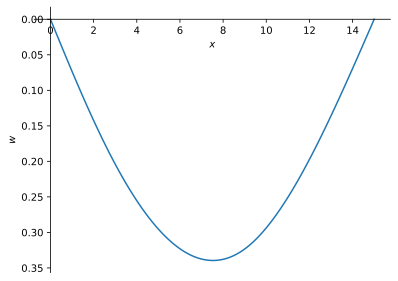

In [9]:
x_numpy = np.linspace(0,15,100)
plt.figure()
plt.plot(x_numpy,w_numpy(x_numpy))
plt.xlabel('$x$')
plt.ylabel('$w$');
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.invert_yaxis()

The dwarskrachtverdeling kan ook worden gevonden:

$$V\left( x \right)=\underbrace{\frac{146{{\left\langle x \right\rangle }^{0}}}{3}+\frac{79{{\left\langle x-15 \right\rangle }^{0}}}{3}}_{\text{oplegreacties}}\underbrace{-10{{\left\langle x \right\rangle }^{1}}+10{{\left\langle x-4 \right\rangle }^{1}}}_{\text{verdeelde belasting}}\underbrace{-35{{\left\langle x-9 \right\rangle }^{0}}}_{\text{puntlast}}$$

met de volgende code:

In [10]:
display(V.subs(sol))

146*SingularityFunction(x, 0, 0)/3 - 10*SingularityFunction(x, 0, 1) + 10*SingularityFunction(x, 4, 1) - 35*SingularityFunction(x, 9, 0) + 79*SingularityFunction(x, 15, 0)/3

En ook deze formule kan worden omgeschreven naar een formule per domein:

$$\displaystyle \begin{cases} - \frac{79}{3} & \text{for}\: x > 9 \\\frac{26}{3} & \text{for}\: x > 4 \\\frac{146}{3} - 10 x & \text{for}\: x > 0 \end{cases}$$

In [11]:
display(sym.simplify(V.subs(sol).rewrite(sym.Piecewise)))

Piecewise((0, x > 15), (-79/3, x > 9), (26/3, x > 4), (146/3 - 10*x, x > 0), (0, True))

en kan ook worden geplot:

In [12]:
V_numpy = sym.lambdify(x, V.subs(sol).rewrite(sym.Piecewise))

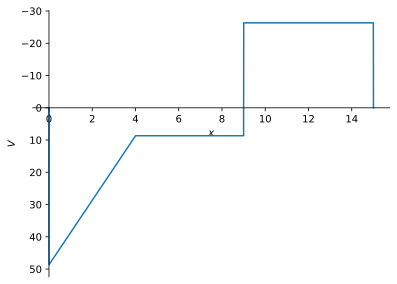

In [13]:
x_numpy = np.linspace(0,15.01,10000)
plt.figure()
plt.plot(x_numpy,V_numpy(x_numpy))
plt.xlabel('$x$')
plt.ylabel('$V$');
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.invert_yaxis()

De verschillende aandelen van verdeelde belastingen, oplegreacties en puntlast kunnen ook los worden geplot:

In [14]:
V_numpy_puntlast = sym.lambdify(x,V.subs(sol).args[0].rewrite(sym.Piecewise))
V_numpy_verdeelde_belasting = sym.lambdify(x,(V.subs(sol).args[1]+V.subs(sol).args[2]).rewrite(sym.Piecewise))
V_numpy_oplegreactie_A = sym.lambdify(x,V.subs(sol).args[4].rewrite(sym.Piecewise))
V_numpy_oplegreactie_B = sym.lambdify(x,V.subs(sol).args[3].rewrite(sym.Piecewise))

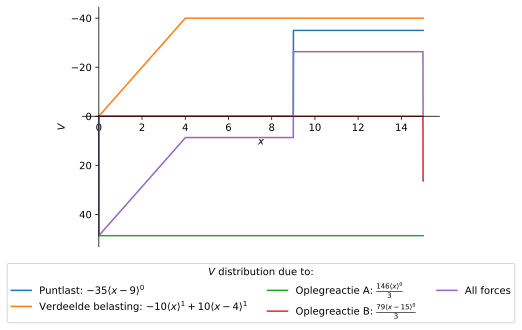

In [17]:
plt.figure()
plt.plot(x_numpy,V_numpy_puntlast(x_numpy),label = 'Puntlast: $'+sym.latex(V.subs(sol).args[0])+'$')
plt.plot(x_numpy,V_numpy_verdeelde_belasting(x_numpy),label = 'Verdeelde belasting: $'+sym.latex(V.subs(sol).args[1]+V.subs(sol).args[2])+'$')
plt.plot(x_numpy,V_numpy_oplegreactie_A(x_numpy),label = 'Oplegreactie A: $'+sym.latex(V.subs(sol).args[4])+'$')
plt.plot(x_numpy,V_numpy_oplegreactie_B(x_numpy),label = 'Oplegreactie B: $'+sym.latex(V.subs(sol).args[3])+'$')
plt.plot(x_numpy,V_numpy(x_numpy),label = 'All forces')
plt.xlabel('$x$')
plt.ylabel('$V$')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.invert_yaxis()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,  box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=False, ncol=3,title="$V$ distribution due to:");